# K Nearest Neighbors

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [4]:
clean_train = "../data/clean/clean_train.csv"
clean_val = "../data/clean/clean_val.csv"
clean_test = "../data/clean/clean_test.csv"
train_subsam = "../data/clean/train_subsam.csv"
train_smote = "../data/clean/train_smote.csv"
k_nn_model = "../models/knn_model.joblib"

num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [5]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [160]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=[target])
X_smote = df_smote.drop(columns=[target])

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [7]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Feature Scaling

**Min-Max Scaling**: Algoritmos sensibles a la escala, como k-Nearest Neighbors (k-NN) y redes neuronales con funciones de activación basadas en distancias (como la función sigmoide), pueden beneficiarse de la normalización.

**Z-Score Scaling**: Algunos algoritmos, como la Regresión Logística y el Support Vector Machine (SVM), funcionan mejor con datos estandarizados, ya que asumen una distribución normal.

In [8]:
scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.fit_transform(X_val[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

df_under[num_cols] = scaler.fit_transform(df_under[num_cols])
df_smote[num_cols] = scaler.fit_transform(df_smote[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
185885,26,29,0,20,30,12,0.316344,0.0002,0,0,0,0,0,1,0.005331,0.011698,0.010600,0.896907
489278,4,5,0,13,35,2,0.140598,0.0025,0,0,0,0,0,0,0.031113,0.065619,0.049255,0.742268
147352,13,16,0,16,44,1,0.149385,0.0005,0,0,1,0,0,0,0.008390,0.018095,0.015444,0.845361


## Model Training

### Correlation Analysis

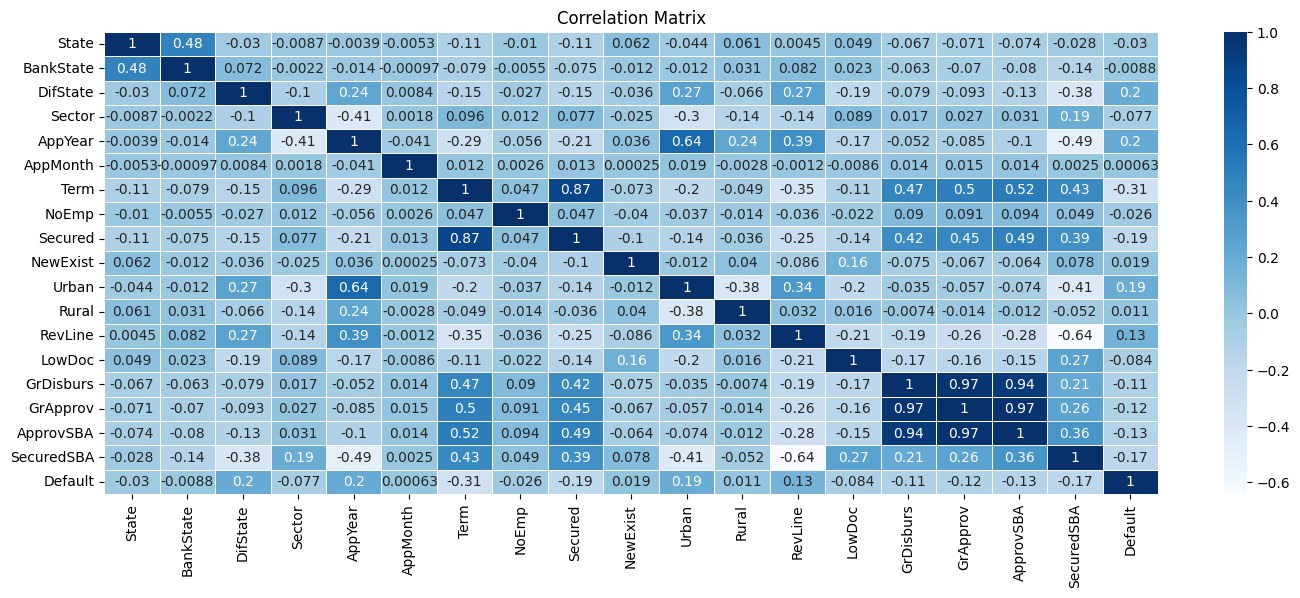

In [9]:
corr_mat = df_train.corr()

plt.figure(figsize=(17, 6))
sns.heatmap(corr_mat, annot=True, cmap="Blues", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Variance Inflation Factor

**Multicolinealidad**: Es una condicion que ocurre cuando algunas variables predictoras del modelo estan correlacionadas con otras variables predictoras, la multicolinealidad severa es problematica, porque puede incrementar la varianza de los coeficientes haciendolos inestables.

**Factor de Inflacion de la Varianza (VIF)**: Proporciona un índice que mide hasta qué punto la varianza de un coeficiente de regresión se incrementa a causa de la colinealidad (VIF = 1 / (1 - R2)).

- **VIF = 1**: Las variables no están correlacionadas.
- **VIF < 5**: Las variables tienen una correlación moderada y se pueden quedar en el modelo.
- **VIF > 5**: Las variables están altamente correlacionadas y deben desaparecer del modelo.

In [10]:
X_vif = sm.add_constant(X_train)

vif = pd.DataFrame()
vif["Variable"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, var) for var in range(X_vif.shape[1])]
vif

,Variable,VIF
0,const,225.941590
1,State,1.336442
2,BankState,1.358568
3,DifState,1.208622
4,Sector,1.229643
5,AppYear,3.649402
6,AppMonth,1.011230
7,Term,4.833288
8,NoEmp,1.013134
9,Secured,4.393292


In [11]:
threshold = 5
vif_cols = list(vif[vif["VIF"] <= threshold]["Variable"])

print(vif_cols)

['State', 'BankState', 'DifState', 'Sector', 'AppYear', 'AppMonth', 'Term', 'NoEmp', 'Secured', 'NewExist', 'Urban', 'Rural', 'RevLine', 'LowDoc', 'SecuredSBA']


### Model Tuning

In [12]:
param_grid = {"n_neighbors": [10, 20, 30],
              "weights": ["uniform", "distance"],
              "metric": ["manhattan", "euclidean"]}

In [13]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
grid_knn.fit(X_train[vif_cols], y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': [10, 20, 30],
                         'weights': ['uniform', 'distance']})

In [15]:
params = grid_knn.best_params_

print("Better Parameters:", params)

Better Parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}


In [170]:
knn_model = KNeighborsClassifier(n_neighbors=10,
                                 weights="uniform",
                                 metric="manhattan")
knn_model.fit(X_train[vif_cols], y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [29]:
acc_val = knn_model.score(X_val[vif_cols], y_val)

print("Accuracy:", round(acc_val, 4))

Accuracy: 0.862


### Feature Selection

In [65]:
sel_k_best = SelectKBest(score_func=chi2, k=10)
sel_k_best.fit(X_train[vif_cols], y_train)

SelectKBest(score_func=<function chi2 at 0x139cda8e0>)

In [66]:
sel_indices = sel_k_best.get_support(indices=True)
sel_cols = np.array(X_train[vif_cols].columns)[sel_indices]

print(sel_cols)

['State' 'DifState' 'Sector' 'AppYear' 'Term' 'Secured' 'Urban' 'RevLine'
 'LowDoc' 'SecuredSBA']


In [67]:
knn_sel = KNeighborsClassifier(n_neighbors=10,
                               weights="uniform",
                               metric="manhattan")
knn_sel.fit(X_train[sel_cols], y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [81]:
acc_sel = knn_sel.score(X_val[sel_cols], y_val)

print("Accuracy:", round(acc_sel, 4))

Accuracy: 0.8809


### Balanced Datasets

**Subsample Dataset**

In [72]:
knn_under = KNeighborsClassifier(n_neighbors=10,
                                 weights="uniform",
                                 metric="manhattan")
knn_under.fit(X_under[sel_cols], y_under)

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [73]:
acc_under = knn_under.score(X_val[sel_cols], y_val)

print("Accuracy:", round(acc_under, 4))

Accuracy: 0.2733


**SMOTE Dataset**

In [74]:
knn_smote = KNeighborsClassifier(n_neighbors=10,
                                 weights="uniform",
                                 metric="manhattan")
knn_smote.fit(X_smote[sel_cols], y_smote)

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [75]:
acc_smote = knn_smote.score(X_val[sel_cols], y_val)

print("Accuracy:", round(acc_smote, 4))

Accuracy: 0.4963


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [82]:
results = cross_val_score(knn_sel, X_test[sel_cols], y_test, cv=10)

print("Results:", results)
print("Accuracy (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.86356877 0.86825279 0.86513011 0.86483271 0.86713755 0.86565056
 0.86475836 0.86438662 0.86742509 0.86630976]
Accuracy (mean +/- desv): 0.8657 +/- 0.0014


In [83]:
y_cv_test = cross_val_predict(knn_sel, X_test[sel_cols], y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy:", round(acc_cv_test, 4))

Accuracy: 0.8657


**Model Scores**

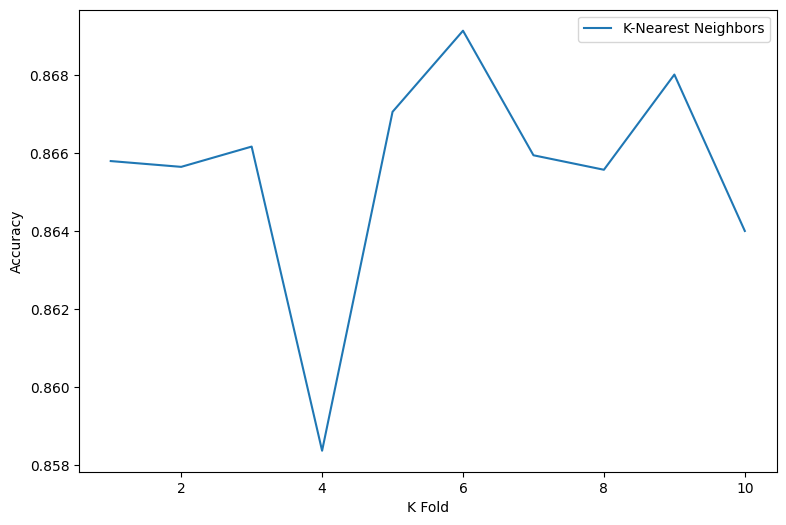

In [84]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(knn_sel, X_test[sel_cols], y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="K-Nearest Neighbors")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
# plt.xlim([1, 10])
# plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [89]:
y_pred = knn_sel.predict(X_test[sel_cols])

In [90]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8705
Precisión:    0.8357
Sensibilidad: 0.6724
F1-score:     0.7130


In [91]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8773    0.9796    0.9256    110629
           1     0.7940    0.3652    0.5003     23869

    accuracy                         0.8705    134498
   macro avg     0.8357    0.6724    0.7130    134498
weighted avg     0.8625    0.8705    0.8501    134498



**Confusion Matrix**

In [92]:
cm_knn = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_knn)

[[0.80571458 0.01681809]
 [0.11265595 0.06481137]]


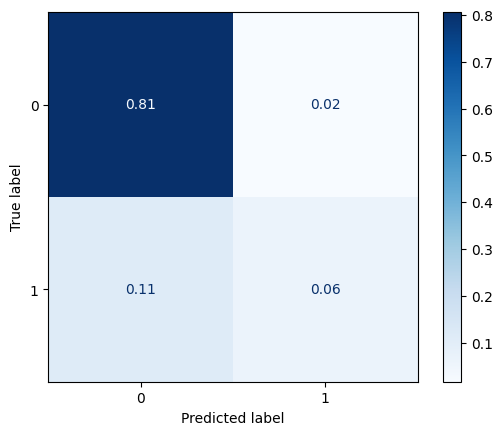

In [93]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                              display_labels=knn_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

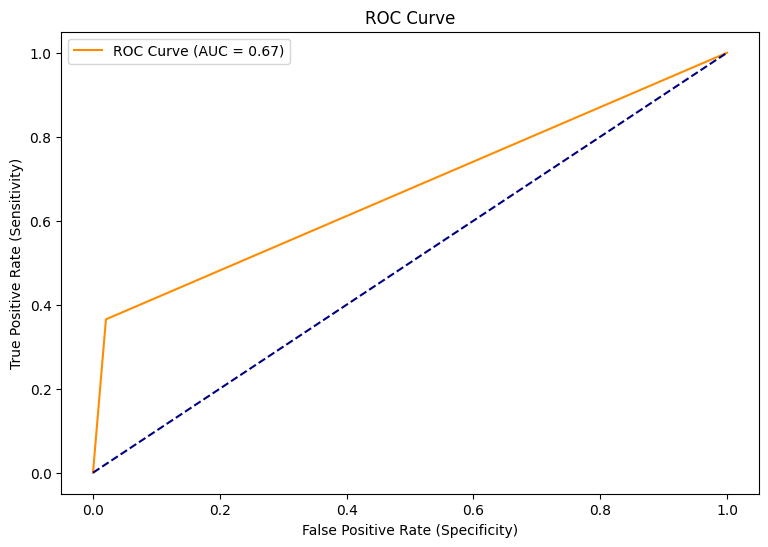

In [94]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [156]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.encoders = {}

    def fit(self, X, y=None):
        for var in self.variables:
            encoder = MinMaxScaler()
            encoder.fit(X[var].values.reshape(-1, 1))
            self.encoders[var] = encoder
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for var, encoder in self.encoders.items():
            X[var] = encoder.transform(X[var].values.reshape(-1, 1))
        return X

In [157]:
class KNeighborsModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.knn = KNeighborsClassifier(n_neighbors=10,
                                        weights="uniform",
                                        metric="manhattan")
        self.pred_cols = ["State", "DifState", "Sector", "AppYear", "Term", 
                          "Secured", "Urban", "RevLine", "LowDoc", "SecuredSBA"]

    def fit(self, X, y):
        self.knn.fit(X[self.pred_cols], y)
        return self

    def predict(self, X, y=None):
        X_ = X[self.pred_cols].copy()
        y_pred = self.knn.predict(X_)
        return y_pred

In [158]:
knn_pipeline = Pipeline([
    ("scaler", MinMaxTransformer(num_cols)),
    ("custom_model", KNeighborsModel())
    ])

### Test the Pipeline

**Internal Partition**

In [161]:
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_val)

In [152]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.8880
Precisión:    0.8533
Sensibilidad: 0.7282
F1-score:     0.7690


**External Partition**

In [162]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"Train: {X_train_val.shape} {y_train_val.shape}")

Train: (761222, 18) (761222,)


In [163]:
knn_pipeline.fit(X_train_val, y_train_val)

y_pred = knn_pipeline.predict(X_test)

In [164]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8896
Precisión:    0.8561
Sensibilidad: 0.7329
F1-score:     0.7737


**The Best Model**

In [165]:
knn_pipeline.fit(X_train_val, y_train_val)

y_pred = knn_pipeline.predict(X_test)

In [166]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8896
Precisión:    0.8561
Sensibilidad: 0.7329
F1-score:     0.7737


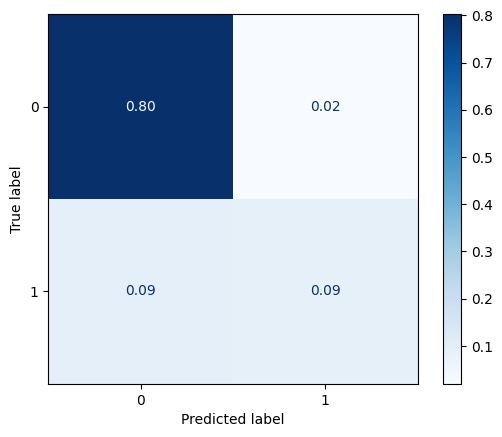

In [171]:
cm_knn = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                              display_labels=knn_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

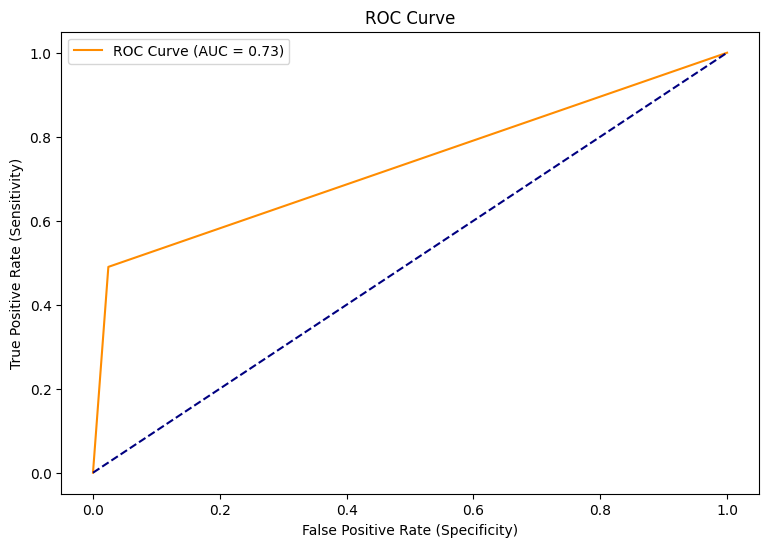

In [172]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Pipeline

In [135]:
joblib.dump(knn_pipeline, k_nn_model)

knn_model = joblib.load(k_nn_model)

try:
    knn_model
    print(f"k-nearest neighbors is loaded...")

except Exception as err:
    print("Error:", str(err))

k-nearest neighbors is loaded...


In [136]:
y_pred = knn_model.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [143]:
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
56098,48,53,0,16,37,8,0.190045,0.0001,0,0,1,0,0,0,0.011201,0.025237,0.023911,0.845361,0,0
23656,22,25,0,12,40,4,0.149321,0.0012,0,0,1,0,0,0,0.020189,0.045009,0.025003,0.484536,0,0
57188,38,41,0,20,19,3,0.190045,0.0001,0,1,0,0,0,0,0.009185,0.020804,0.020891,0.896907,1,1
22231,3,45,1,20,27,2,0.678733,0.0026,1,0,0,0,0,0,0.044471,0.098420,0.087543,0.793814,0,0
25251,34,49,1,0,38,6,0.190045,0.0006,0,0,1,0,0,1,0.006457,0.014803,0.014057,0.845361,0,0
23696,34,37,0,13,33,1,0.271493,0.0002,0,0,0,0,0,1,0.007366,0.016803,0.015002,0.793814,0,0
1988,27,45,1,13,42,3,0.140271,0.0004,0,0,1,0,0,0,0.034467,0.076415,0.063729,0.742268,1,0
119543,4,5,0,13,33,10,0.678733,0.0003,1,0,0,0,0,0,0.011913,0.026805,0.022391,0.742268,0,0
10817,34,37,0,4,40,9,0.190045,0.0002,0,0,1,0,1,0,0.004183,0.004801,0.002667,0.484536,0,0
72586,35,38,0,20,30,4,0.420814,0.0019,0,0,0,0,0,0,0.025100,0.055811,0.046561,0.742268,0,0
